# krigingを実装する

In [2]:
import calc_variogram as variogram
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import stats
import scipy.optimize as opt
import statsmodels.api as sm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# データの用意
data = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_raw.csv')
data['price'] = np.log(data.price)
data = data[['px', 'py', 'price']].values

In [4]:
#バリオグラムの実装
vario = variogram.get_diff(data)

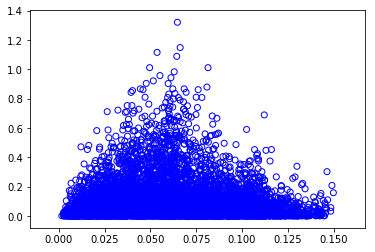

In [5]:
plt.scatter(vario[0], vario[1], facecolors = 'None', edgecolors = 'blue')

In [6]:
e_vario = variogram.emp_variogram(vario, 14)

In [7]:
var, edge, bins = stats.binned_statistic(vario[0], vario[1], statistic=np.var, bins=14)

In [14]:
e_vario[1]/var

array([27.55802626, 19.63073824, 15.76495046, 10.97836938,  9.62527529,
        7.69857213,  8.3486969 , 11.10741175, 18.53175332, 19.13694097,
       15.30346081, 34.72986483, 20.78473127, 27.82177119])

In [8]:
print(e_vario[1])
print(var)

[393. 736. 830. 825. 819. 858. 843. 791. 660. 560. 439. 240.  90.  44.]
[0.00241393 0.00602565 0.01055765 0.02165914 0.02627233 0.03851451
 0.02500775 0.0154048  0.00753222 0.00662256 0.00663569 0.00215456
 0.00360729 0.00376902]


[ 0.00000000e+00  1.00000000e+02  5.04135732e-02 -3.00492471e-01]
[1.00000000e+00 1.00000000e+02 3.82294867e-02 4.67169652e-09
 9.99999736e+01]
[2.00000000e+00 1.00000000e+02 3.82293488e-02 7.90377597e-09
 1.00000000e+02]
[3.00000000e+00 1.00000000e+02 3.82293488e-02 8.34335710e-09
 1.00000000e+02]
[0.        0.0091617 0.0183234 0.0274851 0.0366468 0.0458085 0.0549702
 0.0641319 0.0732936 0.0824553]
0.05041357318789714 -0.3004924706686776
[ 0.00000000e+00  1.00000000e+02  5.04135732e-02 -3.00492471e-01]


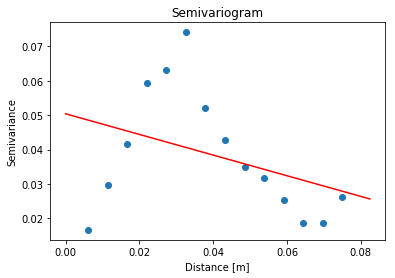

In [10]:
param, lag_num, fig = variogram.auto_vario(vario, 14)

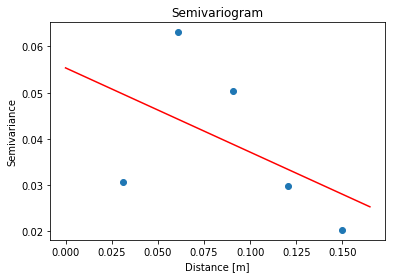

In [18]:
fig # 最小二乗誤差を最小化するbins, model, parameterのバリオグラム

In [19]:
print(param)
print(lag_num)

[ 0.00000000e+00  1.00000000e+02  5.53698639e-02 -1.82289447e-01]
5


## krigingを実装する
 - step1~4

### Step1 OLS残差を導出

In [11]:
data = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_raw.csv')
data['price'] = np.log(data.price)

In [12]:
data.head()

,px,py,price,station,tokyo
0,139.362310,35.733850,11.938193,0.010620,0.408220
1,139.363027,35.654078,12.055250,0.011653,0.405010
2,139.367082,35.659859,12.287653,0.010110,0.400614
3,139.369003,35.645546,12.061047,0.004172,0.399719
4,139.371526,35.647323,12.013701,0.007247,0.397050


In [13]:
x = data[['station', 'tokyo']]
y = data['price']

In [14]:
step1 = sm.OLS(y, x)
step1_res = step1.fit()

In [15]:
step1_res.summary()  # 駅距離の係数がプラスになっているのはおかしい

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.337e+04
Date:                Sat, 16 Mar 2019   Prob (F-statistic):          1.94e-147
Time:                        16:11:45   Log-Likelihood:                -158.76
No. Observations:                 128   AIC:                             321.5
Df Residuals:                     126   BIC:                             327.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
station       53.2124     18.775      2.834      0.005      16.057      90.368
tokyo         33.2437      0.480     69.221      0.000      32.293      34.194
==============================================================================
Omnibus:                        5.919   Durbin-Watson:                   0.412
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                5.152
Skew:                          -0.408   Prob(JB):                       0.0761
Kurtosis:                       2.452   Cond. No.                         89.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

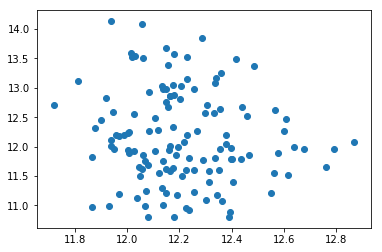

In [16]:
plt.scatter(y, step1_res.fittedvalues)

In [17]:
resid = step1_res.resid

### Step2: Estimation of Semivariogram

 - 残差から理論バリオグラムを求める

In [18]:
resid = pd.DataFrame(resid, columns=['residuals'])
resid = data[['px', 'py']].join(resid)
resid = resid.values

In [19]:
vario = variogram.get_diff(resid)

In [20]:
vario[0]

array([0.07977522, 0.07414472, 0.08855728, ..., 0.00499936, 0.01262236,
       0.00762327])

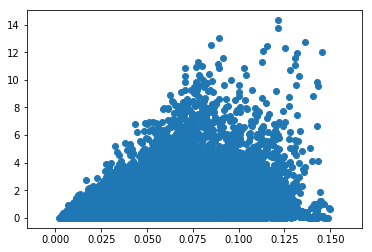

In [21]:
plt.scatter(vario[0], vario[1])

In [22]:
e_vario, lag = variogram.emp_variogram(vario, 14)

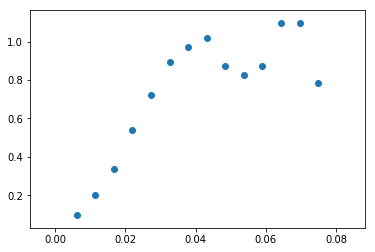

In [23]:
plt.scatter(e_vario[0], e_vario[1])

[  0.         100.           0.25772863  11.83045977]
[1.00000000e+00 1.00000000e+02 2.51870094e-19 9.55335130e-01
 2.28943081e-02]
[2.00000000e+00 1.00000000e+02 8.32742902e-17 1.10239909e+00
 2.89467942e-02]
[3.00000000e+00 1.00000000e+02 7.95844448e-22 9.46576789e-01
 4.96359269e-02]
[0.        0.0091617 0.0183234 0.0274851 0.0366468 0.0458085 0.0549702
 0.0641319 0.0732936 0.0824553]
[0.        0.0091617 0.0183234 0.0274851 0.0366468 0.0458085 0.0549702
 0.0641319 0.0732936 0.0824553] 0.9553351302689328 0.02289430808576946
[1.00000000e+00 1.00000000e+02 2.51870094e-19 9.55335130e-01
 2.28943081e-02]


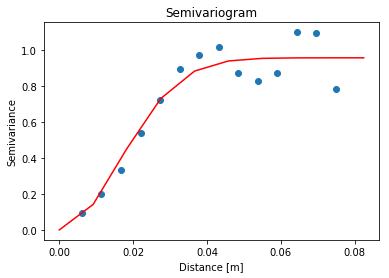

In [24]:
param, lag, fig = variogram.auto_vario(vario, 14)

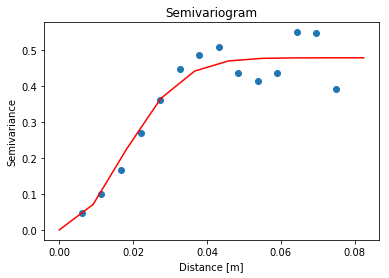

In [43]:
fig

In [44]:
print(param)

[1.00000000e+00 1.00000000e+02 1.86906671e-14 4.77667570e-01
 2.28943090e-02]


### Step3: Estimation of Mean function(param of coefficient)
 - 重みの推定量$\hat{\Sigma} = (\hat{C}(s_i - s_j))_{ij}$
 - $\hat{C}(s_i - s_j) = \hat{C}(0) - \gamma(s_i - s_j; \hat{\theta})$
 - $\hat{C}(0) = \lim_{h\to\infty} \gamma(h;\theta)$

#### Todo
- これ以降の部分の関数化

ガウス型なので有効レンジは$\sqrt{3}r$

In [25]:
ef_range = np.sqrt(3)*param[4]

In [26]:
c0 = variogram.gaussian_model(ef_range, param[2], param[3], param[4])

In [130]:
print(c0)

0.9077717948240113


In [28]:
len(resid)

128

In [29]:
points = data[['px', 'py']].values
distance = scipy.spatial.distance.pdist(points)
distance =scipy.spatial.distance.squareform(distance)

In [30]:
print(distance)

[[0.         0.07977522 0.07414472 ... 0.1456904  0.14342874 0.14034726]
 [0.07977522 0.         0.00706137 ... 0.10275067 0.10323014 0.10451886]
 [0.07414472 0.00706137 0.         ... 0.10051429 0.10066822 0.10147933]
 ...
 [0.1456904  0.10275067 0.10051429 ... 0.         0.00499936 0.01262236]
 [0.14342874 0.10323014 0.10066822 ... 0.00499936 0.         0.00762327]
 [0.14034726 0.10451886 0.10147933 ... 0.01262236 0.00762327 0.        ]]


In [31]:
def call_model(x, param):
    if param[0] == 0:
        return variogram.liner_model(x, param[2], param[3])
    if param[0] == 1:
        return lambda x: param[3] * np.exp(-x**2 / param[4])
    if param[0] == 2:
        return variogram.exponential_model(x, param[2], param[3], param[4])
    if param[0] == 3:
        return variogram.spherical_model(x, param[2], param[3], param[4])

In [121]:
def est_covario(x, param, c0):
    cond = [x <= 0, x > 0]
    func = [c0, call_model(x, param)]
    return np.piecewise(x, cond, func)

In [122]:
est_sigma = np.vectorize(est_covario, excluded=[1])

In [123]:
sigma_hat = est_sigma(distance, param, c0)

In [124]:
pd.DataFrame(sigma_hat).iloc[0:8, 0:8]

,0,1,2,3,4,5,6,7
0,0.907772,0.723489,0.751401,0.678249,0.686311,0.948444,0.808523,0.718146
1,0.723489,0.907772,0.953257,0.950818,0.950430,0.750801,0.934824,0.949674
2,0.751401,0.953257,0.907772,0.946672,0.947982,0.780412,0.945668,0.951481
3,0.678249,0.950818,0.946672,0.907772,0.954938,0.711308,0.922678,0.951032
4,0.686311,0.950430,0.947982,0.954938,0.907772,0.720850,0.927374,0.953075
5,0.948444,0.750801,0.780412,0.711308,0.720850,0.907772,0.839652,0.753894
6,0.808523,0.934824,0.945668,0.922678,0.927374,0.839652,0.907772,0.939964
7,0.718146,0.949674,0.951481,0.951032,0.953075,0.753894,0.939964,0.907772


In [93]:
pd.DataFrame(sigma_hat).iloc[0:8, 0:8]

,0,1,2,3,4,5,6,7
0,0.453886,0.361745,0.375701,0.339125,0.343156,0.474222,0.404262,0.359073
1,0.361745,0.453886,0.476628,0.475409,0.475215,0.375400,0.467412,0.474837
2,0.375701,0.476628,0.453886,0.473336,0.473991,0.390206,0.472834,0.475740
3,0.339125,0.475409,0.473336,0.453886,0.477469,0.355654,0.461339,0.475516
4,0.343156,0.475215,0.473991,0.477469,0.453886,0.360425,0.463687,0.476538
5,0.474222,0.375400,0.390206,0.355654,0.360425,0.453886,0.419826,0.376947
6,0.404262,0.467412,0.472834,0.461339,0.463687,0.419826,0.453886,0.469982
7,0.359073,0.474837,0.475740,0.475516,0.476538,0.376947,0.469982,0.453886


In [51]:
def convert_with_decomposition(mat, eps=0.0001):
    """
    K' = P D' P^T
    P: eigen vectors matrix
    D: diag eigen values matrix
    D': negative eigen values of D are \epsilon
    """
    eigen_values, eigen_vectors_mat = np.linalg.eig(mat)
    eigen_values[eigen_values <= 0] = eps
    # K' = P D' P^T
    mat_positive_definite = eigen_vectors_mat.dot(np.diag(eigen_values)).dot(eigen_vectors_mat.T)
    return mat_positive_definite

In [92]:
def convert_add_lmd(mat, eps=0.0001):
    """
    K' = K + \lmd I
    \lmd is decided as all eigen values are larger than 0
    """
    mat_positive_definite = np.copy(mat)
    eigen_values = np.linalg.eigvals(mat)
    min_eigen_values = np.min(eigen_values)
    if min_eigen_values < 0:
        lmd = np.real(-min_eigen_values + eps)  # new eigen values are larger than 0
        print(lmd)
        mat_positive_definite += lmd * np.eye(mat.shape[0])
    return mat_positive_definite

正定値でないとエラーを起こすため, 類似の正定値行列へと変換する

In [129]:
sigma_hat_pd = convert_add_lmd(sigma_hat)

0.04766333544492228


In [128]:
print(sigma_hat_pd)

[[0.95543513 0.72348906 0.75140113 ... 0.37801946 0.38897181 0.40411599]
 [0.72348906 0.95543513 0.95325671 ... 0.60239453 0.59980155 0.59282822]
 [0.75140113 0.95325671 0.95543513 ... 0.6144749  0.61364431 0.60926526]
 ...
 [0.37801946 0.60239453 0.6144749  ... 0.95543513 0.95429277 0.94870993]
 [0.38897181 0.59980155 0.61364431 ... 0.95429277 0.95543513 0.95291321]
 [0.40411599 0.59282822 0.60926526 ... 0.94870993 0.95291321 0.95543513]]


In [96]:
gls_mod = sm.GLS(y, x, sigma=sigma_hat_pd)

In [97]:
gls_res = gls_mod.fit()
gls_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.278
Model:                            GLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     24.20
Date:                Sat, 16 Mar 2019   Prob (F-statistic):           1.28e-09
Time:                        16:42:42   Log-Likelihood:                 54.814
No. Observations:                 128   AIC:                            -105.6
Df Residuals:                     126   BIC:                            -99.92
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
station      -21.9543      3.261     -6.733      0.000     -28.407     -15.501
tokyo         31.1427     16.735      1.861      0.065      -1.976      64.261
==============================================================================
Omnibus:                        0.920   Durbin-Watson:                   2.268
Prob(Omnibus):                  0.631   Jarque-Bera (JB):                0.515
Skew:                           0.090   Prob(JB):                        0.773
Kurtosis:                       3.253   Cond. No.                         5.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
gls_res = gls_mod.fit()
gls_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.289
Model:                            GLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     25.64
Date:                Mon, 11 Mar 2019   Prob (F-statistic):           4.54e-10
Time:                        11:16:08   Log-Likelihood:                 57.446
No. Observations:                 128   AIC:                            -110.9
Df Residuals:                     126   BIC:                            -105.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
station      -21.7684      3.260     -6.678      0.000     -28.220     -15.317
tokyo         32.7490     12.280      2.667      0.009       8.447      57.051
==============================================================================
Omnibus:                        1.757   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.415   Jarque-Bera (JB):                1.279
Skew:                           0.203   Prob(JB):                        0.528
Kurtosis:                       3.274   Cond. No.                         3.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [98]:
coeff = gls_res.params

In [99]:
print(coeff)

station   -21.954335
tokyo      31.142747
dtype: float64


In [100]:
resid_gls = gls_res.resid

### Step4: Kriging
 - $\hat{Y}(s_0) = X'(s_0)\hat{\beta}_{fgls} + c'\hat{\Sigma}^{-1}(Y - X'\hat{\beta}_{fgls})$
 - $c = (\hat{C}(s_i - s_{0,j}))_{i,j}$

In [101]:
data.head()

,px,py,price,station,tokyo
0,139.362310,35.733850,11.938193,0.010620,0.408220
1,139.363027,35.654078,12.055250,0.011653,0.405010
2,139.367082,35.659859,12.287653,0.010110,0.400614
3,139.369003,35.645546,12.061047,0.004172,0.399719
4,139.371526,35.647323,12.013701,0.007247,0.397050


In [102]:
mdat = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_pred.csv')

In [103]:
mdat.head()

,px,py,price,station,tokyo
0,139.402984,35.767626,NaN,0.017537,0.374249
1,139.407036,35.767626,NaN,0.013571,0.370307
2,139.411089,35.767626,NaN,0.009675,0.366367
3,139.439457,35.767626,NaN,0.001584,0.338865
4,139.394878,35.763700,NaN,0.026327,0.381271


$X'(s_0)\hat{\beta}_{fgls}$

In [104]:
fitted_val = gls_res.predict(exog=mdat[['station', 'tokyo']])

距離行列を計算する

In [105]:
m_points = mdat[['px', 'py']].values

In [106]:
print(len(m_points))

540


In [107]:
print(m_points[0])

[139.4029835   35.76762601]


In [108]:
np.array([variogram.pdist(np.vstack([m_points[0], point])) for point in points])

array([[0.0528692 ],
       [0.12037306],
       [0.11358982],
       [0.12672097],
       [0.12434785],
       [0.04968004],
       [0.09861384],
       [0.11712259],
       [0.10812436],
       [0.10227943],
       [0.09170956],
       [0.08902305],
       [0.1154376 ],
       [0.05069573],
       [0.12078642],
       [0.11638864],
       [0.09773925],
       [0.12106875],
       [0.09042739],
       [0.04401398],
       [0.12399824],
       [0.04184901],
       [0.07247599],
       [0.10346477],
       [0.04628487],
       [0.11215029],
       [0.11881184],
       [0.10564649],
       [0.08542035],
       [0.07756917],
       [0.06994277],
       [0.09117718],
       [0.10793187],
       [0.11262916],
       [0.08388829],
       [0.0885734 ],
       [0.04056393],
       [0.06825009],
       [0.07475439],
       [0.09367953],
       [0.04550486],
       [0.03438163],
       [0.07694747],
       [0.10003043],
       [0.11130226],
       [0.11860069],
       [0.07431223],
       [0.099

In [109]:
np.array([variogram.pdist(np.vstack([m_points[1], point])) for point in points])

array([[0.05604679],
       [0.12177829],
       [0.11493502],
       [0.1278673 ],
       [0.12543437],
       [0.05218235],
       [0.09986324],
       [0.118167  ],
       [0.10921361],
       [0.10336687],
       [0.09282981],
       [0.09016058],
       [0.11629923],
       [0.05258999],
       [0.12154162],
       [0.11717115],
       [0.09853755],
       [0.12171334],
       [0.09123011],
       [0.0456289 ],
       [0.1245469 ],
       [0.04332914],
       [0.07331126],
       [0.10404572],
       [0.04754943],
       [0.11263065],
       [0.11925405],
       [0.10613922],
       [0.0860274 ],
       [0.07815507],
       [0.07040557],
       [0.09152953],
       [0.10822175],
       [0.11287604],
       [0.08419242],
       [0.088739  ],
       [0.0408142 ],
       [0.06836417],
       [0.0748513 ],
       [0.09375372],
       [0.04563246],
       [0.03451948],
       [0.07694398],
       [0.10002673],
       [0.11123728],
       [0.11849884],
       [0.07404703],
       [0.098

In [110]:
# 予測地点と観測地点距離行列cを作成する
m_list = []
for m_point in m_points:
    column = np.array([variogram.pdist(np.vstack([m_point, point])) for point in points])
    m_list.append(column)
c_mat = np.hstack(m_list)

In [148]:
pd.DataFrame(c_mat).iloc[0:8, 0:8]

,0,1,2,3,4,5,6,7
0,0.052869,0.056047,0.059331,0.084217,0.044178,0.047245,0.050452,0.053772
1,0.120373,0.121778,0.123301,0.136875,0.114156,0.115352,0.116677,0.118126
2,0.113590,0.114935,0.116406,0.129815,0.107497,0.108615,0.109872,0.111262
3,0.126721,0.127867,0.129131,0.140951,0.120954,0.121885,0.122943,0.124125
4,0.124348,0.125434,0.126641,0.138157,0.118697,0.119560,0.120554,0.121674
5,0.049680,0.052182,0.054870,0.077101,0.041928,0.044127,0.046575,0.049235
6,0.098614,0.099863,0.101260,0.114625,0.092745,0.093722,0.094863,0.096161
7,0.117123,0.118167,0.119340,0.130812,0.111570,0.112374,0.113317,0.114396


In [112]:
c_hat = est_sigma(c_mat, param, c0)  # 距離行列に共分散関数を適用

In [113]:
pd.DataFrame(c_hat).iloc[0:8, 0:8]

,0,1,2,3,4,5,6,7
0,0.845538,0.832852,0.819180,0.700834,0.877269,0.866590,0.854814,0.841989
1,0.507333,0.499848,0.491768,0.421471,0.540697,0.534251,0.527125,0.519348
2,0.543749,0.536497,0.528582,0.457598,0.576702,0.570645,0.563842,0.556322
3,0.473739,0.467738,0.461152,0.401128,0.504235,0.499279,0.493663,0.487410
4,0.486230,0.480500,0.474157,0.415027,0.516291,0.511674,0.506370,0.500403
5,0.857703,0.848207,0.837613,0.736867,0.884725,0.877443,0.868975,0.859354
6,0.624716,0.617986,0.610452,0.538165,0.656127,0.650923,0.644835,0.637889
7,0.524732,0.519130,0.512851,0.452430,0.554661,0.550316,0.545222,0.539401


In [147]:
pd.DataFrame(c_hat).iloc[0:8, 0:8]

,0,1,2,3,4,5,6,7
0,0.422769,0.416426,0.409590,0.350417,0.438634,0.433295,0.427407,0.420994
1,0.253667,0.249924,0.245884,0.210735,0.270349,0.267126,0.263563,0.259674
2,0.271875,0.268248,0.264291,0.228799,0.288351,0.285323,0.281921,0.278161
3,0.236869,0.233869,0.230576,0.200564,0.252118,0.249639,0.246831,0.243705
4,0.243115,0.240250,0.237078,0.207513,0.258146,0.255837,0.253185,0.250201
5,0.428851,0.424103,0.418807,0.368433,0.442362,0.438722,0.434487,0.429677
6,0.312358,0.308993,0.305226,0.269082,0.328063,0.325462,0.322418,0.318944
7,0.262366,0.259565,0.256425,0.226215,0.277330,0.275158,0.272611,0.269701


$c'\hat{\Sigma}^{-1}$

In [114]:
krig_weight = np.dot(c_hat.T, np.linalg.inv(sigma_hat))

In [131]:
print(krig_weight)

[[ 0.1375585  -0.01243937 -0.00791566 ...  0.06255101 -0.0058103
  -0.08794446]
 [ 0.13379949 -0.00966909 -0.00820266 ...  0.0513265  -0.01347576
  -0.09033438]
 [ 0.12749382 -0.00507183 -0.00707028 ...  0.04186274 -0.01898621
  -0.09012219]
 ...
 [ 0.02350673 -0.03598374 -0.03720665 ... -0.00750816  0.01333319
   0.0318706 ]
 [-0.09138235 -0.06282521 -0.0540371  ... -0.03214869 -0.02035017
  -0.02006986]
 [-0.03878801 -0.05568353 -0.05148057 ... -0.02625611 -0.00719145
   0.00460123]]


$\hat{Y}(s_0) = X'(s_0)\hat{\beta}_{fgls} + c'\hat{\Sigma}^{-1}(Y - X'\hat{\beta}_{fgls})$

In [115]:
kriging_pred_val = fitted_val + np.dot(krig_weight, resid_gls)

In [127]:
print(fitted_val)

0      11.270117
1      11.234445
2      11.197283
3      10.518420
4      11.295858
5      11.257782
6      11.218125
7      11.175638
8      11.127546
9      11.067076
10     10.978607
11     10.844034
12     10.670683
13     10.541057
14     10.487861
15     10.437765
16     11.040340
17     10.965049
18     10.865448
19     10.734568
20     10.574956
21     10.458173
22     10.413020
23     10.369026
24     11.083759
25     10.983263
26     10.848651
27     10.684069
28     10.500433
29     10.433097
         ...    
510    10.428998
511    10.233212
512    10.074660
513     9.995002
514     9.890524
515     9.755664
516    11.333107
517    11.293686
518    11.234122
519    11.068515
520    10.861866
521    10.703702
522    10.557392
523    10.386110
524    10.204532
525    10.026141
526     9.937583
527     9.828694
528    11.472214
529    11.369320
530    11.320238
531    10.845767
532    10.647056
533    10.501714
534    10.339134
535    10.165166
536     9.982047
537     9.8797

Rで予測した場合との比較

In [116]:
res_inR = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/krig_res_R.csv')
res_inR = res_inR.iloc[:, 1:-2]

In [117]:
res_inR.head()

,px,py,var1.pred
0,139.402984,35.767626,11.646464
1,139.407036,35.767626,11.709496
2,139.411089,35.767626,11.776675
3,139.439457,35.767626,12.073558
4,139.394878,35.763700,11.524789


Text(0, 0.5, 'pred by Python')

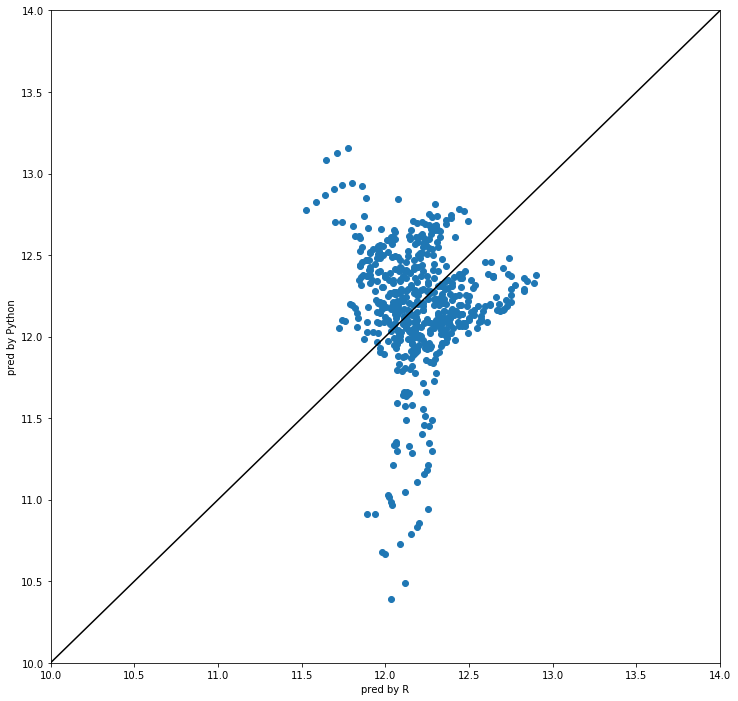

In [126]:
res_fig = plt.figure(figsize=(12, 12))
res_ax = res_fig.add_subplot(1, 1, 1)
res_ax.scatter(res_inR['var1.pred'], kriging_pred_val)
res_ax.plot(np.linspace(10, 14, 1000), np.linspace(10, 14, 1000), color='black')
res_ax.set_xlim(10, 14)
res_ax.set_ylim(10, 14)
res_ax.set_xlabel('pred by R')
res_ax.set_ylabel('pred by Python')

In [176]:
res_fig.savefig('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/plot/kriging_res_with_Python.png')